In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Advanced models
from xgboost import XGBClassifier
# or LightGBM if available
# from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [6]:
train_df = pd.read_parquet("train.parquet")
test_df  = pd.read_parquet("test.parquet")
sample_sub = pd.read_parquet("sample_submission.parquet")

In [9]:
train_df.shape



(1639424, 7)

In [8]:
test_df.shape

(409856, 7)

In [10]:
train_df.head()

,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


In [11]:
train_df.columns


Index(['Date', 'X1', 'X2', 'X3', 'X4', 'X5', 'target'], dtype='object')

In [12]:
TARGET = "target"

In [13]:
train_df[TARGET].value_counts(normalize=True)


target
0    0.991437
1    0.008563
Name: proportion, dtype: float64

In [15]:
train_df.target.describe()

count     1639424
unique          2
top             0
freq      1625386
Name: target, dtype: object

In [16]:
train_df.isnull().sum().sort_values(ascending=False)


Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64

<Axes: xlabel='target', ylabel='Count'>

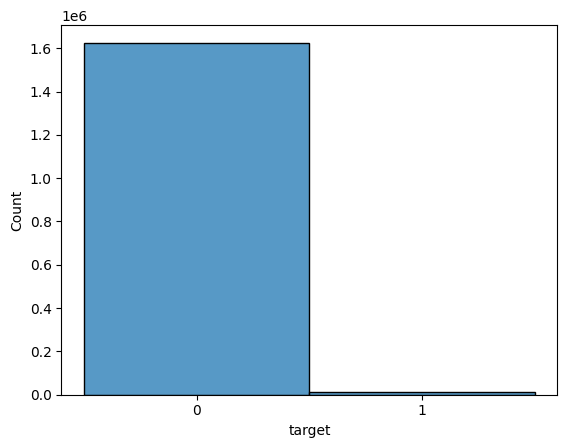

In [55]:
sns.histplot(train_df.target)

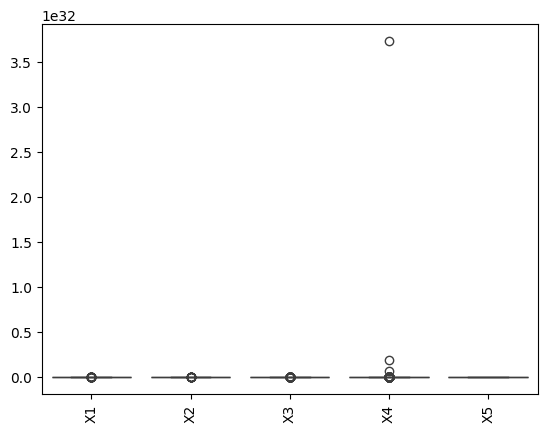

In [17]:
sns.boxplot(data=train_df.sample(1000))
plt.xticks(rotation=90)
plt.show()


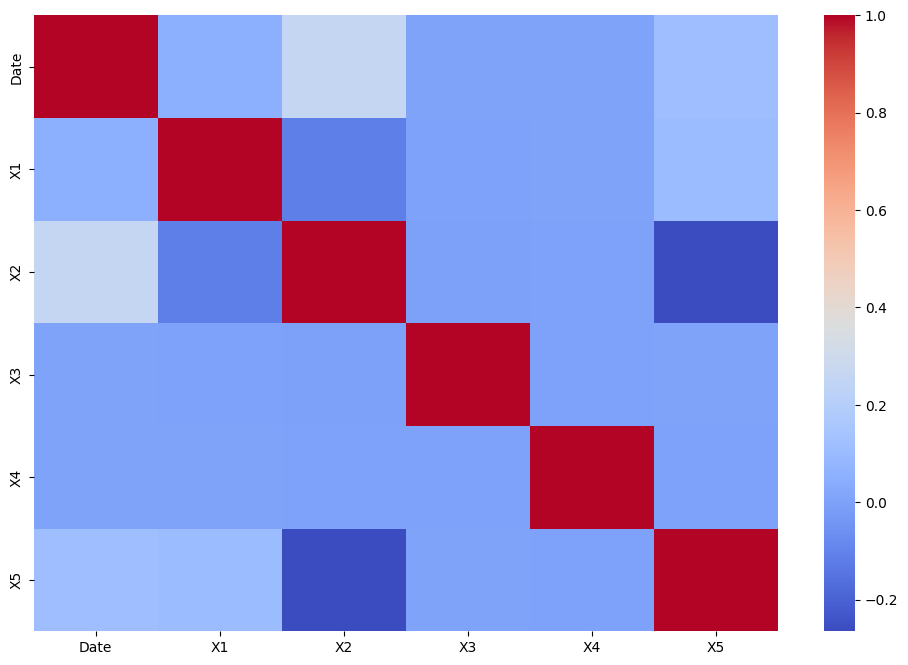

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(train_df.drop(columns=[TARGET]).corr(), cmap="coolwarm")
plt.show()


In [19]:
X = train_df.drop(columns=[TARGET])
y = train_df[TARGET]


In [29]:
datetime_cols = X.select_dtypes(include=["datetime64[ns]"]).columns
datetime_cols


Index(['Date'], dtype='object')

In [30]:
for col in datetime_cols:
    X[col + "_hour"] = X[col].dt.hour
    X[col + "_day"] = X[col].dt.day
    X[col + "_dayofweek"] = X[col].dt.dayofweek

    test_df[col + "_hour"] = test_df[col].dt.hour
    test_df[col + "_day"] = test_df[col].dt.day
    test_df[col + "_dayofweek"] = test_df[col].dt.dayofweek


In [31]:
X = X.drop(columns=datetime_cols)
test_df = test_df.drop(columns=datetime_cols)


In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [35]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(X_train_scaled, y_train)

lr_preds = lr.predict(X_val_scaled)

print("Logistic Regression Results")
print(classification_report(y_val, lr_preds))


Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      0.86      0.93    325077
           1       0.05      0.88      0.10      2808

    accuracy                           0.86    327885
   macro avg       0.53      0.87      0.51    327885
weighted avg       0.99      0.86      0.92    327885



In [39]:
rf = RandomForestClassifier(
    n_estimators=150,     # reduce trees
    max_depth=15,         # limit tree depth
    min_samples_leaf=10,  # prevent overfitting
    class_weight="balanced",
    n_jobs=-1,            # USE ALL CPU CORES 🔥
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,150
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
y = train_df[TARGET].astype(int)


In [45]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [46]:
print("y_train unique:", y_train.unique(), y_train.dtype)
print("y_val unique:", y_val.unique(), y_val.dtype)


y_train unique: [0 1] int64
y_val unique: [0 1] int64


In [47]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_val)

print("XGBoost Results")
print(classification_report(y_val, xgb_preds))


XGBoost Results
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    325077
           1       0.19      0.93      0.31      2808

    accuracy                           0.96    327885
   macro avg       0.59      0.95      0.65    327885
weighted avg       0.99      0.96      0.98    327885



In [51]:
# 🔥 FORCE EVERYTHING TO INT (FINAL SAFETY NET)
y_val_eval = y_val.astype(int)

lr_preds_eval = pd.Series(lr_preds).astype(int)
rf_preds_eval = pd.Series(rf_preds).astype(int)
xgb_preds_eval = pd.Series(xgb_preds).astype(int)


In [52]:
from sklearn.metrics import f1_score, classification_report

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "F1 Score": [
        f1_score(y_val_eval, lr_preds_eval, average="macro"),
        f1_score(y_val_eval, rf_preds_eval, average="macro"),
        f1_score(y_val_eval, xgb_preds_eval, average="macro")
    ]
})

results


,Model,F1 Score
0,Logistic Regression,0.511591
1,Random Forest,0.863016
2,XGBoost,0.647555


In [53]:
print("Logistic Regression")
print(classification_report(y_val_eval, lr_preds_eval))

print("Random Forest")
print(classification_report(y_val_eval, rf_preds_eval))

print("XGBoost")
print(classification_report(y_val_eval, xgb_preds_eval))


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.86      0.93    325077
           1       0.05      0.88      0.10      2808

    accuracy                           0.86    327885
   macro avg       0.53      0.87      0.51    327885
weighted avg       0.99      0.86      0.92    327885

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.92      0.60      0.73      2808

    accuracy                           1.00    327885
   macro avg       0.96      0.80      0.86    327885
weighted avg       1.00      1.00      1.00    327885

XGBoost
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    325077
           1       0.19      0.93      0.31      2808

    accuracy                           0.96    327885
   macro avg       0.59      0.95      0.65    327885
weighted avg       0.99      0.9